### ARMA(p,q)
### ARIMA(p,d,q)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# statmodel
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
# datetime
from datetime import datetime
# Warnings filter
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('us_airline_carrier_passenger.csv')
df.head()

,month,passengers
0,2000-01-01,46492
1,2000-02-01,48526
2,2000-03-01,58764
3,2000-04-01,56033
4,2000-05-01,58201


In [3]:
df.isnull().sum()

month         0
passengers    0
dtype: int64

In [4]:
df.shape

(240, 2)

In [5]:
df.dtypes

month         object
passengers     int64
dtype: object

# Split Data
* traindata:2000-01-01 to 2016-12-01
* testdata :2017-01-01 to 2019-12-01

In [6]:
df['month']

0      2000-01-01
1      2000-02-01
2      2000-03-01
3      2000-04-01
4      2000-05-01
          ...    
235    2019-08-01
236    2019-09-01
237    2019-10-01
238    2019-11-01
239    2019-12-01
Name: month, Length: 240, dtype: object

### Converting Object to time

In [7]:
df['month'] = pd.to_datetime(df['month'])
# Split the data into train and test
cut_off = datetime.strptime('2016-12-01','%Y-%m-%d')
cut_off

datetime.datetime(2016, 12, 1, 0, 0)

### Splitting Data

In [8]:
train_df = df[df['month'] <= cut_off]
test_df = df[df['month'] > cut_off]

In [9]:
train_df.head()

,month,passengers
0,2000-01-01,46492
1,2000-02-01,48526
2,2000-03-01,58764
3,2000-04-01,56033
4,2000-05-01,58201


In [10]:
test_df.head()

,month,passengers
204,2017-01-01,62621
205,2017-02-01,58377
206,2017-03-01,72962
207,2017-04-01,70262
208,2017-05-01,73679


In [11]:
# Set the time as index
train_df.set_index('month',inplace=True)
test_df.set_index('month',inplace=True)

In [12]:
train_df.head()

,passengers
month,
2000-01-01,46492
2000-02-01,48526
2000-03-01,58764
2000-04-01,56033
2000-05-01,58201


In [13]:
test_df.head()

,passengers
month,
2017-01-01,62621
2017-02-01,58377
2017-03-01,72962
2017-04-01,70262
2017-05-01,73679


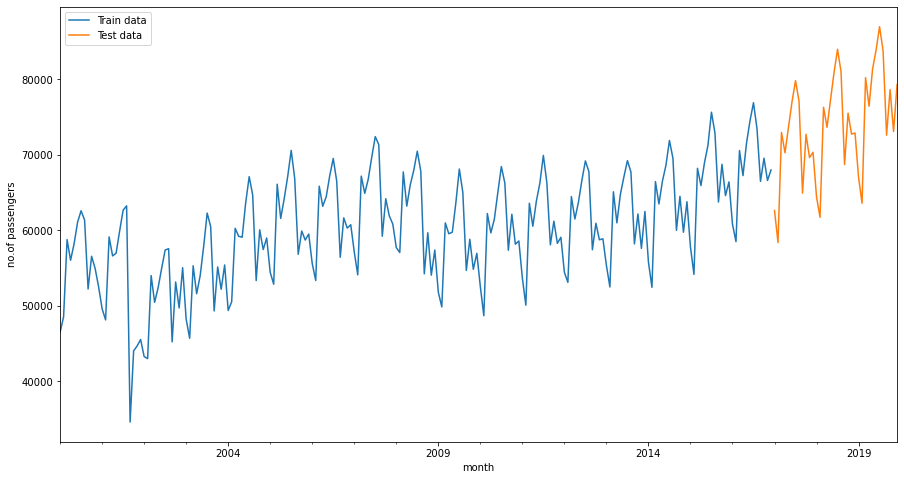

In [14]:
#Visualisng
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax)
test_df.plot(kind='line',ax=ax)
plt.xlabel('month')
plt.ylabel('no.of passengers')
plt.legend(['Train data','Test data'])
plt.show()

# ARMA(p,q)
#### Steps for ARMA
* 1.Augumented Dickey-Fuller unit root test for Statonary
* 2.If not stationary convert into Stationary
* 3.Find p,q : 
*              p : AR order(pacf)-- Auto Regressive Order
*              q : MA order(acf)--Moving Average Order
* 4.Train ARMA model
* Convert the Statonary to non Statonary

### Step1 : To check the data Stationary or not
* We use Augmented Dickey-Fuller unit root test for Stationary
* Checking Hypothesis testing
- Significance level =5%
- p-value = 0.025
* H0: Data is non-stationary(p-value >= 0.025):bluk region
* Ha: Data is stationary(p-value<0.025):critical region

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
adfuller(train_df)

(-0.9529124941948456,
 0.7700488660390636,
 13,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 3449.617955746232)

* Here the second value false in the bulk region its not below 0.025 the data is not stationary 

## Step-2 : Converting Non-stationary to Stationary

In [17]:
stationary_train_df = train_df.diff() #diffrence
stationary_train_df.dropna(inplace=True) #drop the null value

<AxesSubplot:xlabel='month'>

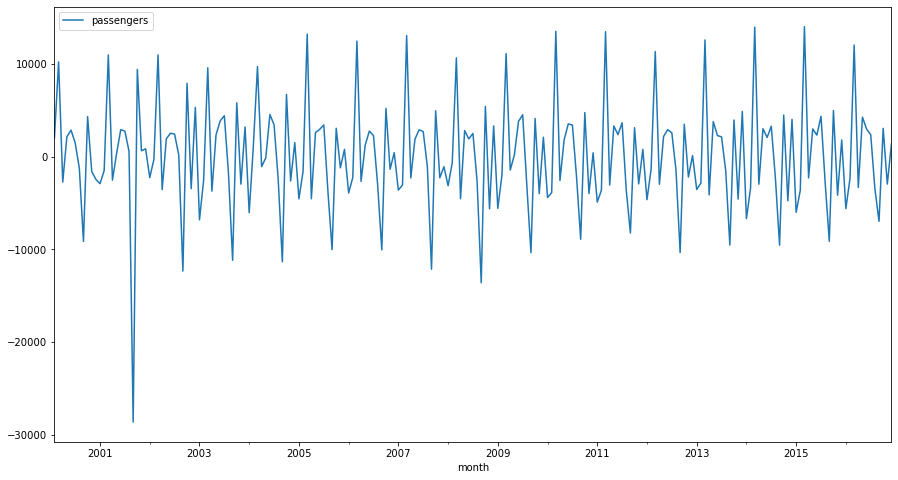

In [18]:
fig,ax = plt.subplots(figsize=(15,8))
stationary_train_df.plot(kind='line',ax=ax)

In [19]:
# Checking for Stationary
adfuller(stationary_train_df)

(-3.77000389812238,
 0.003229563894313956,
 12,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 3430.804868488187)

* from the above region is 0.003 which is less than 0.025,p-values falls in critical region
* Hence p-value falls in critical region hence we reject null hypothesis and accept alternate hypothesis(data is stationary)

# Step-3 : Find p,q
* p: Ar order(pacf)
* q: MA order(acf)

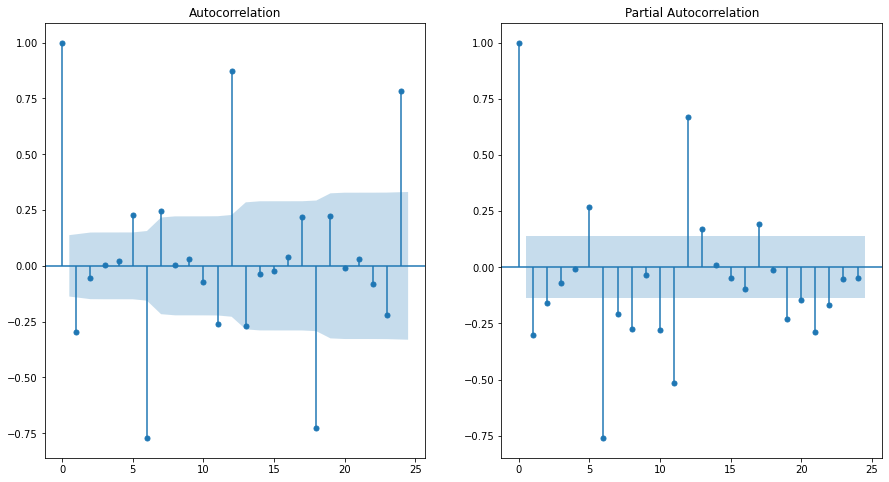

In [20]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
fig = plot_acf(stationary_train_df,ax=ax[0])
fig = plot_pacf(stationary_train_df,ax=ax[1])

* Selecting greater than haf the cycle is good ex:6, p=6,q=6

# Step-4 : Train ARMA Model

In [21]:
p,q = (6,6)
model_arma = ARMA(stationary_train_df,order=(p,q)).fit()

* Evaluation

In [22]:
model_arma.aic # error value lower the value its better

3775.722349731129

* Really not that bad

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
fitted_values = model_arma.fittedvalues

In [25]:
mse = mean_squared_error(stationary_train_df,fitted_values)
print('mean square error =',mse)

mean square error = 7506215.523106293


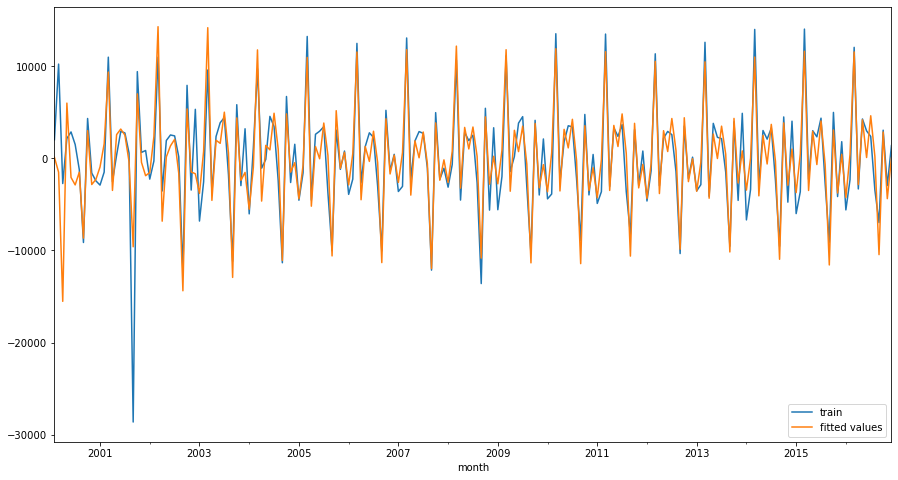

In [26]:
# Visualisation 
fig,ax = plt.subplots(figsize=(15,8))
stationary_train_df.plot(kind='line',ax=ax)
fitted_values.plot(kind='line',ax=ax)
plt.legend(['train','fitted values'])

* Placing to our Original data
* Forcasting

In [27]:
start_date = datetime.strptime('2017-01-01','%Y-%m-%d')
end_date = datetime.strptime('2019-12-01','%Y-%m-%d')
preddection_values = model_arma.predict(start=start_date,end=end_date)

In [28]:
preddection_values

2017-01-01   -4439.566840
2017-02-01    -689.645022
2017-03-01    9843.307521
2017-04-01   -3124.862725
2017-05-01    4225.206190
2017-06-01     -78.896871
2017-07-01    4719.445632
2017-08-01    1007.228030
2017-09-01   -9433.230378
2017-10-01    3409.081058
2017-11-01   -4006.724018
2017-12-01     372.533232
2018-01-01   -4571.083662
2018-02-01    -895.168658
2018-03-01    9450.287495
2018-04-01   -3269.065774
2018-05-01    4209.250814
2018-06-01    -246.020390
2018-07-01    4840.394427
2018-08-01    1199.308064
2018-09-01   -9048.789835
2018-10-01    3550.364178
2018-11-01   -3987.322433
2018-12-01     544.785260
2019-01-01   -4681.937003
2019-02-01   -1074.139123
2019-03-01    9074.390807
2019-04-01   -3407.184712
2019-05-01    4186.813456
2019-06-01    -422.913536
2019-07-01    4941.616256
2019-08-01    1365.506430
2019-09-01   -8681.386369
2019-10-01    3685.096886
2019-11-01   -3962.237076
2019-12-01     725.850058
Freq: MS, dtype: float64

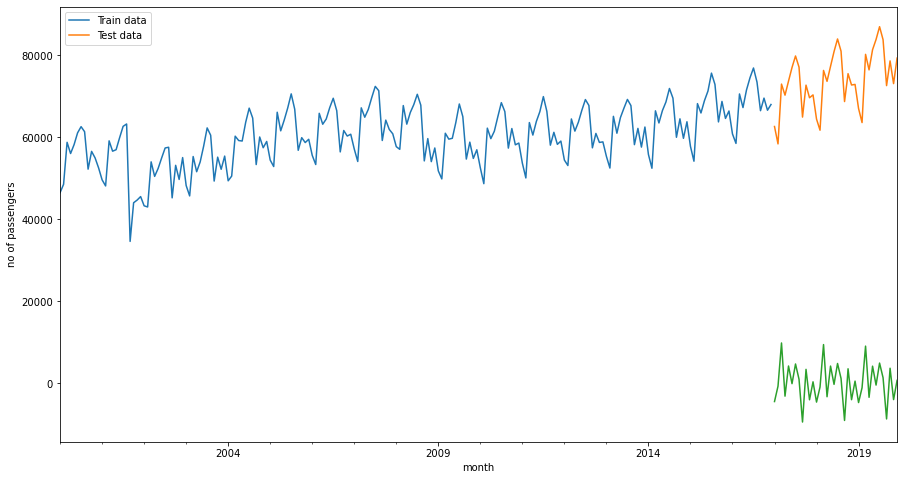

In [29]:
# Visualising
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax)
test_df.plot(kind='line',ax=ax)

preddection_values.plot(kind='line',ax=ax)
plt.xlabel('month')
plt.ylabel('no of passengers')
plt.legend(['Train data','Test data'])
plt.show()

* Converting Stationary to non-stationary

In [30]:
# we were intialsisng value means our last value is intial value
train_df.iloc[-1]

passengers    67983
Name: 2016-12-01 00:00:00, dtype: int64

* Its our last value in the data set

In [31]:
# Stationary o non-stationary
intial_value = 67983
forecasted_values = intial_value + preddection_values.cumsum()

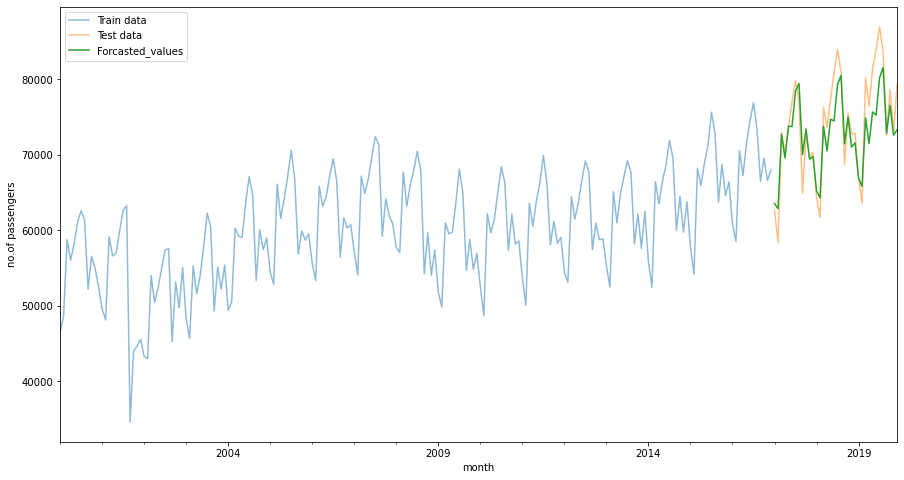

In [32]:
# Visualising
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax,alpha=0.5)
test_df.plot(kind='line',ax=ax,alpha=0.5)

forecasted_values.plot(kind='line',ax=ax)
plt.xlabel('month')
plt.ylabel('no.of passengers')
plt.legend(['Train data','Test data','Forcasted_values'])
plt.show()

## ARIMA(p,d,q)
* (6,0,6)

In [33]:
model_arima = ARIMA(stationary_train_df,order=(6,0,6)).fit()

In [34]:
start_date = datetime.strptime('2017-01-01','%Y-%m-%d')
end_date = datetime.strptime('2019-12-01','%Y-%m-%d')
predicted_value_arima = model_arima.predict(start=start_date,end=end_date) #stationary

In [35]:
train_df.iloc[-1]

passengers    67983
Name: 2016-12-01 00:00:00, dtype: int64

In [36]:
forcasted_values_arima = 67983 + np.cumsum(predicted_value_arima)
forcasted_values_arima

2017-01-01    63543.433160
2017-02-01    62853.788137
2017-03-01    72697.095658
2017-04-01    69572.232933
2017-05-01    73797.439124
2017-06-01    73718.542252
2017-07-01    78437.987884
2017-08-01    79445.215914
2017-09-01    70011.985536
2017-10-01    73421.066595
2017-11-01    69414.342577
2017-12-01    69786.875809
2018-01-01    65215.792147
2018-02-01    64320.623488
2018-03-01    73770.910983
2018-04-01    70501.845209
2018-05-01    74711.096024
2018-06-01    74465.075633
2018-07-01    79305.470060
2018-08-01    80504.778124
2018-09-01    71455.988289
2018-10-01    75006.352467
2018-11-01    71019.030034
2018-12-01    71563.815294
2019-01-01    66881.878291
2019-02-01    65807.739168
2019-03-01    74882.129975
2019-04-01    71474.945263
2019-05-01    75661.758719
2019-06-01    75238.845183
2019-07-01    80180.461439
2019-08-01    81545.967869
2019-09-01    72864.581501
2019-10-01    76549.678386
2019-11-01    72587.441310
2019-12-01    73313.291368
Freq: MS, dtype: float64

In [37]:
len(forcasted_values_arima)

36

In [38]:
# Confidence interval
for_val = model_arima.forecast(steps=36)

In [39]:
for_val 

(array([-4439.56684027,  -689.64502246,  9843.30752083, -3124.86272489,
         4225.20619042,   -78.89687128,  4719.44563192,  1007.22803017,
        -9433.23037795,  3409.08105825, -4006.72401758,   372.53323185,
        -4571.08366209,  -895.16865847,  9450.28749462, -3269.06577386,
         4209.25081436,  -246.02039037,  4840.3944272 ,  1199.30806371,
        -9048.78983523,  3550.36417837, -3987.32243346,   544.78526043,
        -4681.93700311, -1074.13912342,  9074.39080712, -3407.18471193,
         4186.81345573,  -422.91353602,  4941.61625641,  1365.50643033,
        -8681.38636867,  3685.09688572, -3962.23707603,   725.85005757]),
 array([2318.04588162, 2352.82028529, 2366.85704147, 2375.37563394,
        2386.71603272, 2419.92679026, 2429.85361808, 2460.20774456,
        2472.06516239, 2479.49181171, 2489.57379174, 2521.08920102,
        2531.32403906, 2557.96878611, 2567.99861567, 2574.48640173,
        2583.45706948, 2613.44488002, 2623.95968765, 2647.45423048,
        26

In [40]:
# Confidence interval 
confidence_interval = model_arima.forecast(steps=36)[-1]

In [41]:
confidence_interval

array([[ -8982.85328275,    103.71960221],
       [ -5301.08804372,   3921.7979988 ],
       [  5204.352963  ,  14482.26207866],
       [ -7780.51341716,   1530.78796738],
       [  -452.67127502,   8903.08365587],
       [ -4821.86622541,   4664.07248285],
       [   -42.97994722,   9481.87121105],
       [ -3814.69054365,   5829.14660399],
       [-14278.38906367,  -4588.07169224],
       [ -1450.63359265,   8268.79570916],
       [ -8886.19898625,    872.7509511 ],
       [ -4568.71080396,   5313.77726766],
       [ -9532.38761186,    390.22028768],
       [ -5908.69535282,   4118.35803587],
       [  4417.10269557,  14483.47229368],
       [ -8314.96639995,   1776.83485222],
       [  -854.23199743,   9272.73362615],
       [ -5368.27823079,   4876.23745005],
       [  -302.47205748,   9983.26091188],
       [ -3989.60687876,   6388.22300617],
       [-14254.33282793,  -3843.24684253],
       [ -1666.29750869,   8767.02586543],
       [ -9219.62350291,   1244.97863599],
       [ -4

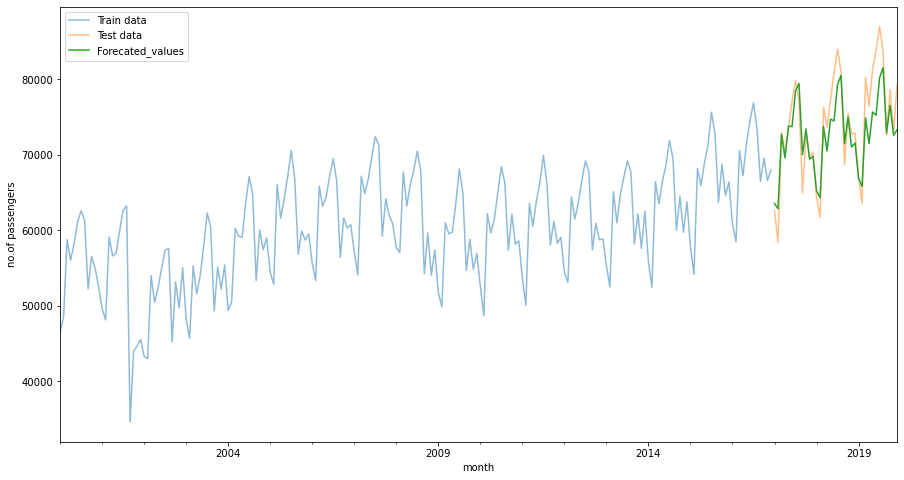

In [42]:
# Visualising 
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax,alpha=0.5)
test_df.plot(kind='line',ax=ax,alpha=0.5)

forecasted_values.plot(kind='line',ax=ax)
plt.xlabel('month')
plt.ylabel('no.of passengers')
plt.legend(['Train data','Test data','Forecated_values'])
plt.show()

In [43]:
upper_lmt = forcasted_values_arima + confidence_interval[:,1]
upper_lmt

2017-01-01    63647.152762
2017-02-01    66775.586136
2017-03-01    87179.357737
2017-04-01    71103.020901
2017-05-01    82700.522780
2017-06-01    78382.614735
2017-07-01    87919.859095
2017-08-01    85274.362518
2017-09-01    65423.913844
2017-10-01    81689.862304
2017-11-01    70287.093528
2017-12-01    75100.653077
2018-01-01    65606.012435
2018-02-01    68438.981524
2018-03-01    88254.383277
2018-04-01    72278.680061
2018-05-01    83983.829650
2018-06-01    79341.313083
2018-07-01    89288.730972
2018-08-01    86893.001130
2018-09-01    67612.741446
2018-10-01    83773.378333
2018-11-01    72264.008670
2018-12-01    77396.933777
2019-01-01    67509.372368
2019-02-01    70083.786933
2019-03-01    89320.756817
2019-04-01    73441.719553
2019-05-01    85236.425282
2019-06-01    80257.271307
2019-07-01    90584.942332
2019-08-01    88410.524122
2019-09-01    69694.090007
2019-10-01    85754.167411
2019-11-01    74156.914888
2019-12-01    79621.952049
Freq: MS, dtype: float64

In [44]:
lower_lmt = forcasted_values_arima + confidence_interval[:,0]
lower_lmt

2017-01-01    54560.579877
2017-02-01    57552.700094
2017-03-01    77901.448621
2017-04-01    61791.719516
2017-05-01    73344.767849
2017-06-01    68896.676027
2017-07-01    78395.007937
2017-08-01    75630.525371
2017-09-01    55733.596473
2017-10-01    71970.433002
2017-11-01    60528.143591
2017-12-01    65218.165005
2018-01-01    55683.404535
2018-02-01    58411.928136
2018-03-01    78188.013679
2018-04-01    62186.878809
2018-05-01    73856.864026
2018-06-01    69096.797402
2018-07-01    79002.998003
2018-08-01    76515.171245
2018-09-01    57201.655461
2018-10-01    73340.054959
2018-11-01    61799.406531
2018-12-01    66820.267332
2019-01-01    56890.510208
2019-02-01    59383.413155
2019-03-01    78592.284747
2019-04-01    62693.801549
2019-05-01    74460.719067
2019-06-01    69374.591986
2019-07-01    79659.213059
2019-08-01    77412.424477
2019-09-01    58672.300257
2019-10-01    74715.383133
2019-11-01    63093.493580
2019-12-01    68456.330802
Freq: MS, dtype: float64

TypeError: fill_between() missing 1 required positional argument: 'y1'

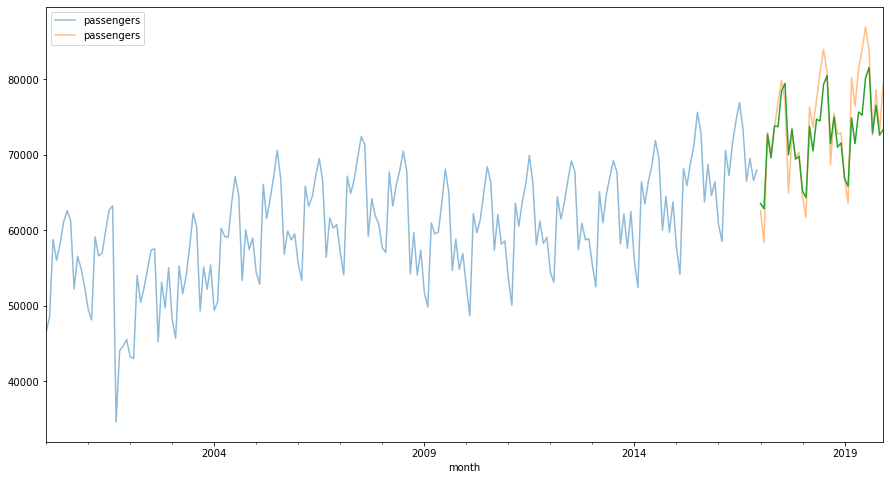

In [45]:
# Visualising
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax,alpha=0.5)
test_df.plot(kind='line',ax=ax,alpha=0.5)

forcasted_values_arima.plot(kind='line',ax=ax)
plt.fill_between(test_df.index)
plt.xlabel('month')
plt.ylabel('no.of passengers')
plt.legend(['Train data','Test data','Forecated_values'])
plt.show()

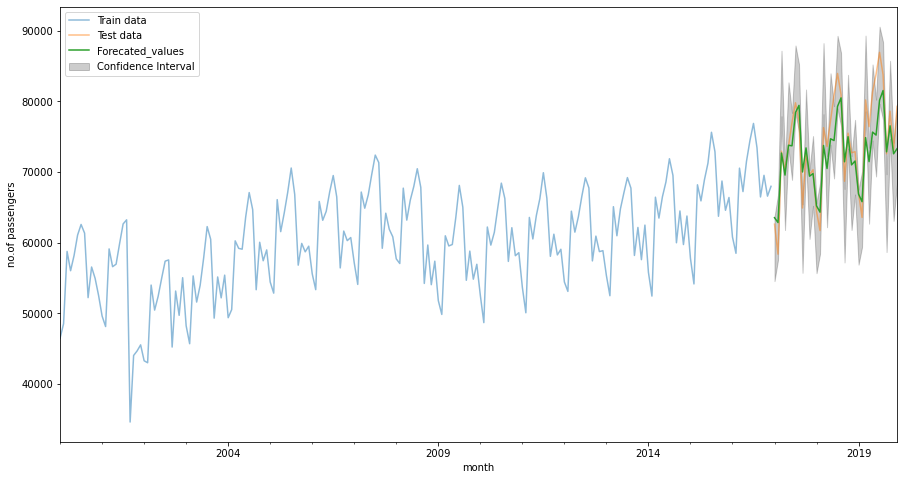

In [46]:
# Visualising
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax,alpha=0.5)
test_df.plot(kind='line',ax=ax,alpha=0.5)

forcasted_values_arima.plot(kind='line',ax=ax)
plt.fill_between(test_df.index,lower_lmt,upper_lmt,color = 'k',alpha=0.2)

plt.xlabel('month')
plt.ylabel('no.of passengers')
plt.legend(['Train data','Test data','Forecated_values','Confidence Interval'])
plt.show()

In [47]:
!pip install pmdarima

You should consider upgrading via the 'c:\users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


# Auto Arima

In [48]:
from pmdarima import auto_arima

In [49]:
auto_model = auto_arima(stationary_train_df,start_p=12,d=0,start_q=6,max_p=24,
                       max_d=2,max_q=24,seasonal=False,stationary=True,trace=True,
                       scoring='mse')

Performing stepwise search to minimize aic
 ARIMA(12,0,6)(0,0,0)[0] intercept   : AIC=3758.330, Time=1.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4100.940, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4084.137, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4078.462, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4099.007, Time=0.00 sec
 ARIMA(11,0,6)(0,0,0)[0] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(12,0,5)(0,0,0)[0] intercept   : AIC=3765.293, Time=1.29 sec
 ARIMA(13,0,6)(0,0,0)[0] intercept   : AIC=3759.911, Time=1.43 sec
 ARIMA(12,0,7)(0,0,0)[0] intercept   : AIC=3752.101, Time=1.55 sec
 ARIMA(11,0,7)(0,0,0)[0] intercept   : AIC=3739.212, Time=1.44 sec
 ARIMA(10,0,7)(0,0,0)[0] intercept   : AIC=3753.059, Time=1.26 sec
 ARIMA(11,0,8)(0,0,0)[0] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(10,0,6)(0,0,0)[0] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(10,0,8)(0,0,0)[0] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(12,0,8)(0,0,0)[0] intercept   : AIC=

In [50]:
model_arima_best = ARIMA(stationary_train_df,(11,0,7)).fit()

# Caliculating values

In [51]:
# make predections
start_date = datetime.strptime('2017-01-01','%Y-%m-%d')
end_date = datetime.strptime('2019-12-01','%Y-%m-%d')

# Predection values

In [52]:
prediction_arima_best = model_arima_best.predict(start_date,end_date)

In [53]:
#Predicting last value
train_df.iloc[-1]

passengers    67983
Name: 2016-12-01 00:00:00, dtype: int64

In [54]:
forecasted_values_arima_best = 67983 + np.cumsum(prediction_arima_best)

# Visualisation

<AxesSubplot:xlabel='month'>

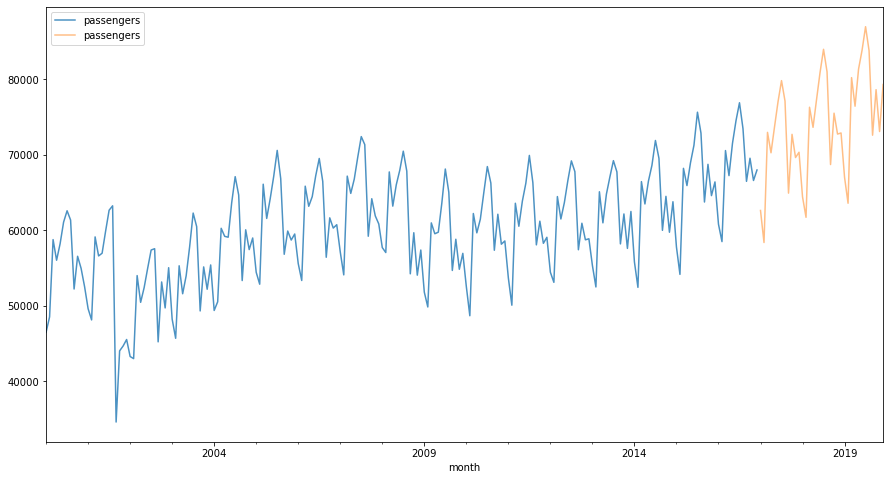

In [55]:
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax,alpha=0.8)
test_df.plot(kind='line',ax=ax,alpha=0.5)

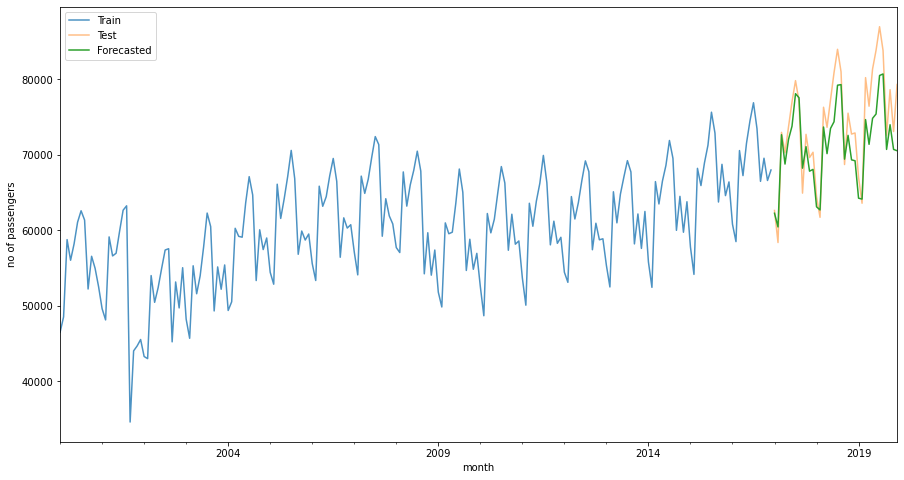

In [56]:
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax,alpha=0.8)
test_df.plot(kind='line',ax=ax,alpha=0.5)

#Forcasting
forecasted_values_arima_best.plot(kind='line',ax=ax)
plt.ylabel('no of passengers')
plt.legend(['Train','Test','Forecasted'])
plt.show()